#### **0 Imports**

In [450]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from statsmodels.tsa.arima_model import ARMA
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch, het_breuschpagan
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from arch import arch_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import pylab
from statsmodels.api import qqplot
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg
import scipy.stats as stats
warnings.filterwarnings('ignore')

In [395]:
def plot_acf_and_pacf(serie, nlags=30):
    lag_acf = acf(serie, nlags=nlags)
    lag_pacf = pacf(serie, nlags = nlags, method='ols')
    
    #Plot ACF
    plt.rcParams["figure.figsize"] = (15,8)
    plt.subplot(121) 
    plt.plot(lag_acf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(serie)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(serie)),linestyle='--',color='gray')
    plt.title('Autocorrelation Function')
    
    
    #Plot PACF
    plt.subplot(122)
    plt.plot(lag_pacf)
    plt.axhline(y=0,linestyle='--',color='gray')
    plt.axhline(y=-1.96/np.sqrt(len(serie)),linestyle='--',color='gray')
    plt.axhline(y=1.96/np.sqrt(len(serie)),linestyle='--',color='gray') 
    plt.title('Partial Autocorrelation Function') 
    plt.tight_layout()

#### **1.0 Load Data and Treatment**

In [396]:
data = pd.read_excel('./data/exchange_rate.xlsx')
data.shape

(7009, 2)

In [397]:
data.head(15)

,JBDCBRL Index,PX_LAST
0,1994-01-04,81.93
1,1994-01-05,82.30
2,1994-01-06,82.65
3,1994-01-07,82.78
4,1994-01-10,84.58
5,1994-01-11,86.21
6,1994-01-12,86.18
7,1994-01-13,85.00
8,1994-01-14,84.98
9,1994-01-18,88.56


###### **1.2 Rename columns and rows**

In [398]:
data = data.rename({'JBDCBRL Index': 'date', 'PX_LAST': 'value'}, axis=1)

###### **1.3 Data types**

In [399]:
data.dtypes

date     datetime64[ns]
value           float64
dtype: object

###### **1.4 Check NaN**

In [400]:
data.isna().sum()

date     0
value    0
dtype: int64

###### **1.5 Numerical Analysis**

In [401]:
num_attributes = data.select_dtypes(include=['float'])

In [402]:
# Central tendency - mean, median
#mean
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
#median
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

#Dispersion - desvio, minimo, maximo, range, skew, kutosi

d1 = pd.DataFrame(num_attributes.apply(np.std)).T

d2 = pd.DataFrame(num_attributes.apply(np.min)).T

d3 = pd.DataFrame(num_attributes.apply(np.max)).T

d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T

d5 = pd.DataFrame(num_attributes.apply(lambda x : x.skew())).T

d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#concat 
h = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
h.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'] 

In [403]:
h

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,value,42.43,109.69,67.26,79.92,79.85,16.62,-0.07,-1.05


#### **2.0 Data Visualization e Testes**

In [404]:
df2 = data.copy()
#df2 = df2.loc[(df2['date'] > '2008-01-01') & (df2['date'] < '2021-12-31')]
df2.head(10)

,date,value
0,1994-01-04,81.93
1,1994-01-05,82.30
2,1994-01-06,82.65
3,1994-01-07,82.78
4,1994-01-10,84.58
5,1994-01-11,86.21
6,1994-01-12,86.18
7,1994-01-13,85.00
8,1994-01-14,84.98
9,1994-01-18,88.56


Text(0.5, 0, 'Data')

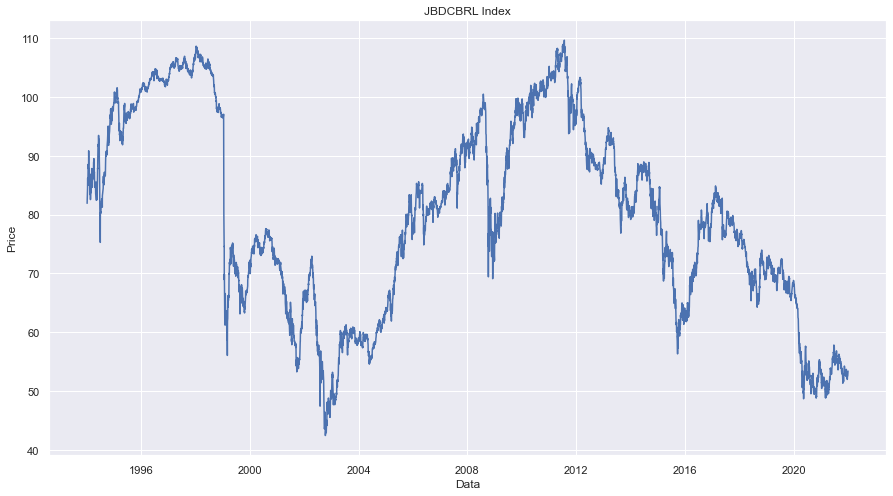

In [405]:
sns.lineplot(x = 'date', y='value', data=df2)
plt.title('JBDCBRL Index')
plt.ylabel('Price')
plt.xlabel('Data')

Text(0.5, 0, 'Data')

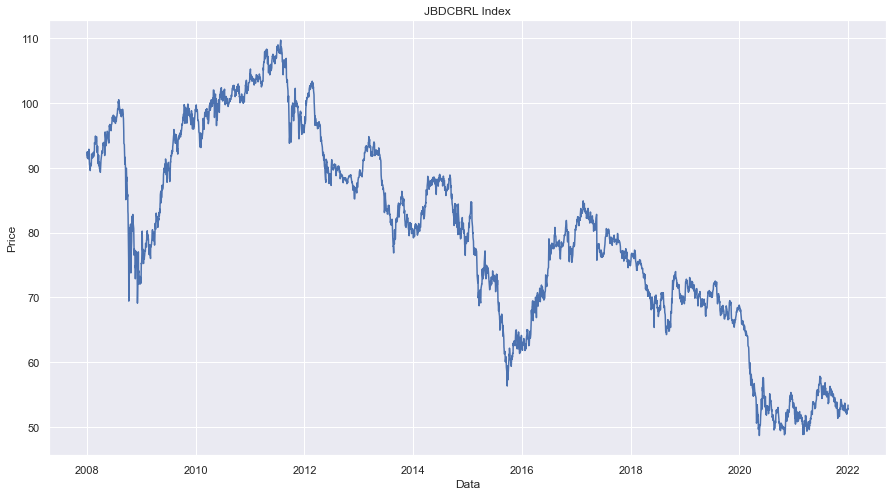

In [406]:
df2 = df2.loc[(df2['date'] > '2008-01-01') & (df2['date'] < '2021-12-31')]
sns.lineplot(x = 'date', y='value', data=df2)
plt.title('JBDCBRL Index')
plt.ylabel('Price')
plt.xlabel('Data')

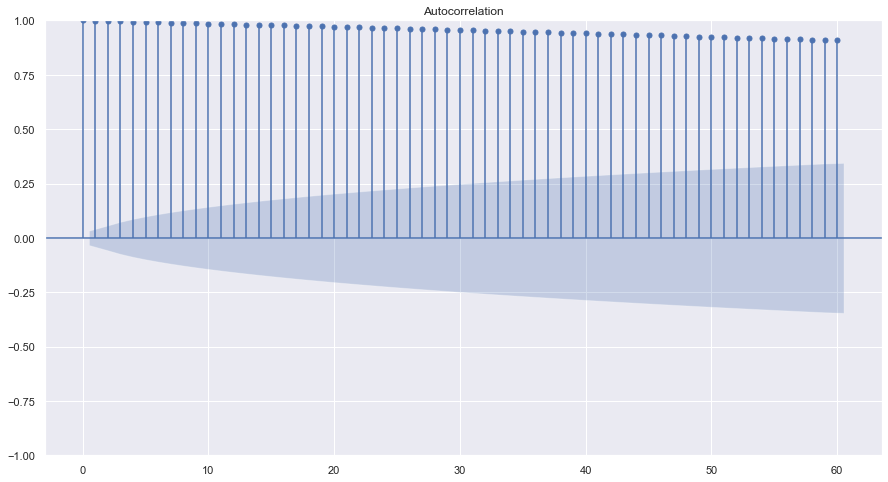

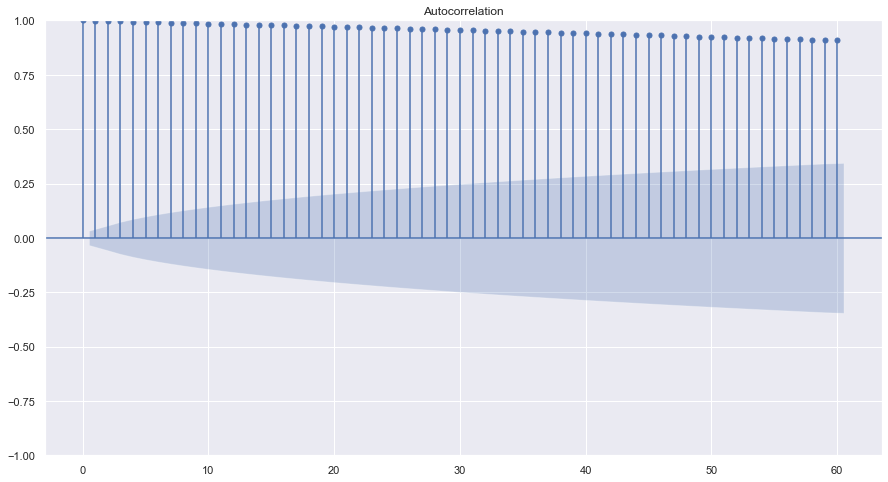

In [407]:
plot_acf(df2['value'], lags=60)

###### **2.1 ADF Test - In nivel**

In [408]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [409]:
adf_test(df2['value'])

Results of Dickey-Fuller Test:
Test Statistic                  -0.74
p-value                          0.83
#Lags Used                       5.00
Number of Observations Used   3509.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


###### **2.2 KPSS - In nivel**

In [410]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [411]:
kpss_test(df2['value'])

Results of KPSS Test:
Test Statistic           7.04
p-value                  0.01
Lags Used               37.00
Critical Value (10%)     0.35
Critical Value (5%)      0.46
Critical Value (2.5%)    0.57
Critical Value (1%)      0.74
dtype: float64


#### **3.0 Retorno e modelagem**

In [412]:
df3 = df2.copy()

Text(0.5, 0, 'Data')

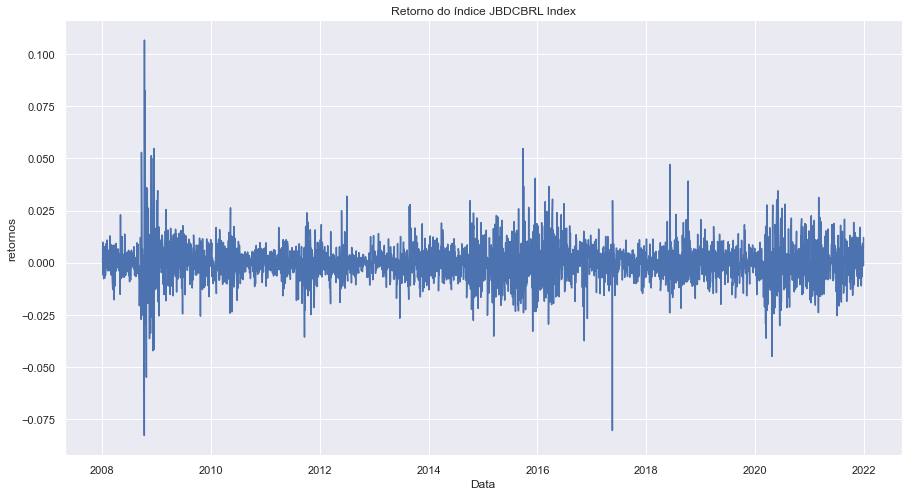

In [413]:
#Retornos
df3['retornos'] = df3['value'].pct_change(periods=1).fillna(0)
df3['retornos_quadrados'] = df3['retornos'] ** 2


#Plot series in 1° diff
sns.lineplot(x = 'date', y='retornos', data=df3)
# sns.lineplot(x = 'date', y='zero', data=df3)

plt.title('Retorno do índice JBDCBRL Index')
plt.xlabel('Data')


Text(0, 0.5, 'Retornos ao quadrado')

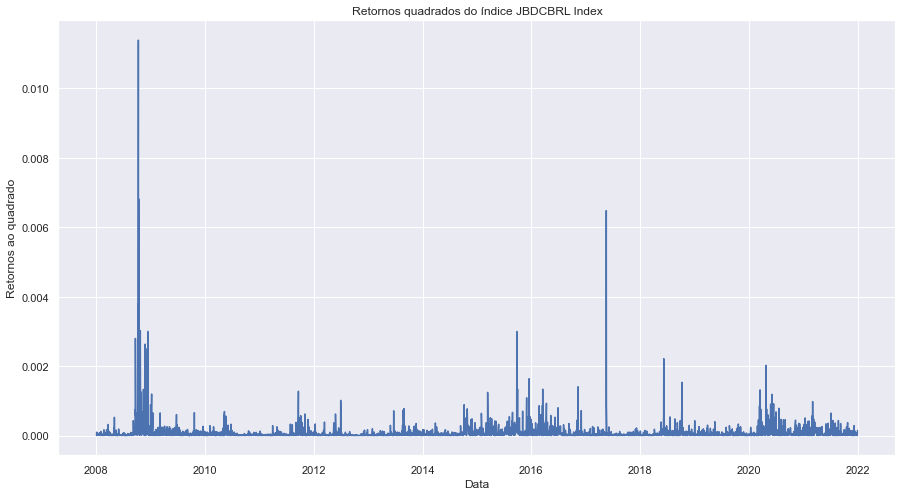

In [414]:
#Retornos ao quadrado
sns.lineplot(x = 'date', y='retornos_quadrados', data=df3)
# sns.lineplot(x = 'date', y='zero', data=df3)

plt.title('Retornos quadrados do índice JBDCBRL Index')
plt.xlabel('Data')
plt.ylabel('Retornos ao quadrado')

##### **3.1 Testes dos retornos**

In [415]:
df4 = df3.dropna()

In [416]:
adf_test(df4['retornos'])

Results of Dickey-Fuller Test:
Test Statistic                 -26.29
p-value                          0.00
#Lags Used                       5.00
Number of Observations Used   3509.00
Critical Value (1%)             -3.43
Critical Value (5%)             -2.86
Critical Value (10%)            -2.57
dtype: float64


In [417]:
kpss_test(df4['retornos'])

Results of KPSS Test:
Test Statistic           0.10
p-value                  0.10
Lags Used               20.00
Critical Value (10%)     0.35
Critical Value (5%)      0.46
Critical Value (2.5%)    0.57
Critical Value (1%)      0.74
dtype: float64


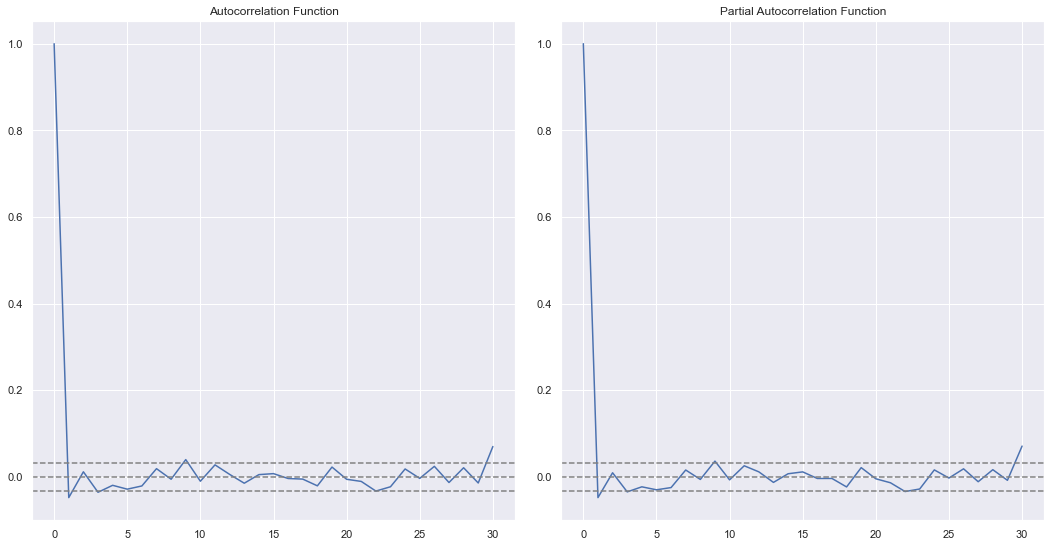

In [418]:
plot_acf_and_pacf(df4['retornos'])

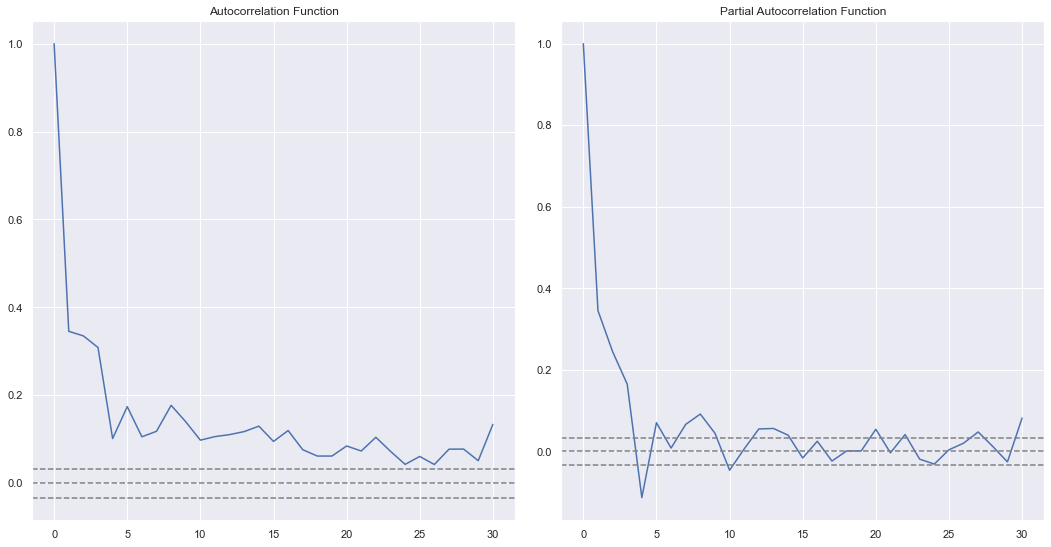

In [419]:
plot_acf_and_pacf(df4['retornos'] ** 2)

In [420]:
acorr_ljungbox(df3['retornos'], lags=[30], return_df = True)

,lb_stat,lb_pvalue
30,63.09,0.00


##### 3.2 Modelagem de volatilidade

In [421]:
#Série estacionária
adfuller(df3['retornos'])

(-26.291439516041173,
 0.0,
 5,
 3509,
 {'1%': -3.4322149444714065,
  '5%': -2.8623640267493293,
  '10%': -2.567208643634359},
 -22513.48740666268)

##### 3.2.1 ARMA(1,1)

In [454]:
model_11 = SARIMAX(df3['retornos'], order=(1,0,1))
model_results_11 = model_11.fit()
model_results_11.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               retornos   No. Observations:                 3515
Model:               SARIMAX(1, 0, 1)   Log Likelihood               11368.789
Date:                Sun, 12 Jun 2022   AIC                         -22731.578
Time:                        19:16:39   BIC                         -22713.084
Sample:                             0   HQIC                        -22724.979
                               - 3515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3824      0.127     -3.001      0.003      -0.632      -0.133
ma.L1          0.3357      0.131      2.571      0.010       0.080       0.592
sigma2      9.082e-05   9.35e-07     97.116      0.000     8.9e-05    9.27e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19117.79
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### 3.2.2 ARMA(2,2)

In [423]:
model = SARIMAX(df3['retornos'], order=(2,0,2))
model_results = model.fit()
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               retornos   No. Observations:                 3515
Model:               SARIMAX(2, 0, 2)   Log Likelihood               11370.197
Date:                Sun, 12 Jun 2022   AIC                         -22730.395
Time:                        19:12:07   BIC                         -22699.571
Sample:                             0   HQIC                        -22719.396
                               - 3515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0847      0.282     -0.301      0.764      -0.637       0.467
ar.L2          0.4397      0.134      3.285      0.001       0.177       0.702
ma.L1          0.0319      0.282      0.113      0.910      -0.521       0.585
ma.L2         -0.4490      0.140     -3.200      0.001      -0.724      -0.174
sigma2      9.066e-05    9.6e-07     94.427      0.000    8.88e-05    9.25e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):             18352.32
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

##### 3.2.3 ARMA(3,3)

In [457]:
model_arma_33 = SARIMAX(df3['retornos'], order=(3,0,3))
model_results_arma_33 = model_arma_33.fit()
model_results_arma_33.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               retornos   No. Observations:                 3515
Model:               SARIMAX(3, 0, 3)   Log Likelihood               11373.512
Date:                Sun, 12 Jun 2022   AIC                         -22733.024
Time:                        19:20:59   BIC                         -22689.871
Sample:                             0   HQIC                        -22717.627
                               - 3515                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9571      0.135      7.069      0.000       0.692       1.222
ar.L2         -0.0115      0.216     -0.053      0.958      -0.435       0.412
ar.L3         -0.4782      0.127     -3.777      0.000      -0.726      -0.230
ma.L1         -1.0055      0.141     -7.144      0.000      -1.281      -0.730
ma.L2          0.0739      0.229      0.323      0.746      -0.374       0.522
ma.L3          0.4278      0.134      3.184      0.001       0.164       0.691
sigma2       9.05e-05   9.53e-07     94.991      0.000    8.86e-05    9.24e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             17774.87
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

###### 3.3.4 Testes nos resíduos do modelo ARMA(3,3)

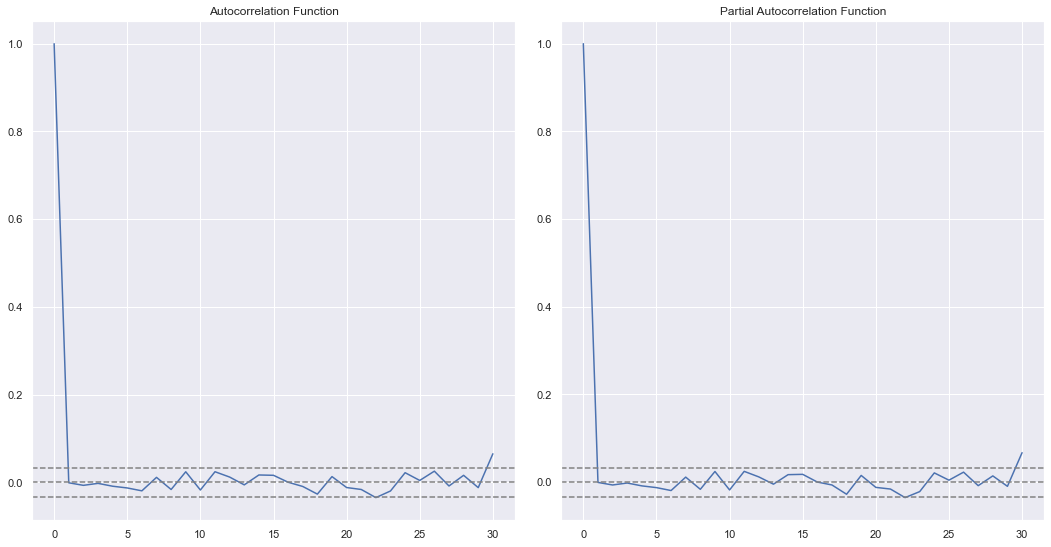

In [456]:
arma_residuals = model_results_arma_33.resid
plot_acf_and_pacf(arma_residuals)

In [427]:
acorr_ljungbox(arma_residuals, return_df = True, lags=[30])

,lb_stat,lb_pvalue
30,51.91,0.01


In [428]:
#Teste de heterocedasticidade
het_arch(arma_residuals)

(742.7384502795977,
 4.1696299672261063e-153,
 93.94939974238117,
 1.6571696330340417e-172)

#### 4.0 Volatilidade

##### 4.1 GARCH(1,1): Distribuição normal

In [429]:
resid_model_11 = arch_model(arma_residuals, p=1, q=1, vol='GARCH') 
resid_model_results_11 = resid_model_11.fit(update_freq=5)
resid_model_results_11.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -11918.584353475537
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                11918.6
Distribution:                  Normal   AIC:                          -23829.2
Method:            Maximum Likelihood   BIC:                          -23804.5
                                        No. Observations:                 3515
Date:                Sun, Jun 12 2022   Df Residuals:                     3514
Time:                        19:12:09   Df Model:                            1
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -6.9077e-06  2.581e-06     -2.677  7.436e-03 [-1.197e-05,-1.850e-06]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.8162e-06  4.451e-12  4.080e+05      0.000 [1.816e-06,1.816e-06]
alpha[1]       0.1000  1.316e-02      7.600  2.959e-14   [7.421e-02,  0.126]
beta[1]        0.8800  1.338e-02     65.784      0.000     [  0.854,  0.906]
============================================================================

Covariance estimator: robust
"""

##### 4.1 GARCH(2,1): Distribuição normal

In [459]:
resid_model_21 = arch_model(arma_residuals, p=2, q=1, vol='GARCH') 
resid_model_results = resid_model_21.fit(update_freq=5)
resid_model_results.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -11914.237602129902
            Iterations: 6
            Function evaluations: 20
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                11914.2
Distribution:                  Normal   AIC:                          -23818.5
Method:            Maximum Likelihood   BIC:                          -23787.7
                                        No. Observations:                 3515
Date:                Sun, Jun 12 2022   Df Residuals:                     3514
Time:                        19:30:02   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -3.2899e-05  1.472e-04     -0.224      0.823 [-3.213e-04,2.555e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.8113e-06  9.692e-14  1.869e+07      0.000 [1.811e-06,1.811e-06]
alpha[1]       0.0500  2.034e-03     24.588 1.718e-133 [4.601e-02,5.399e-02]
alpha[2]       0.0500  1.480e-02      3.379  7.285e-04 [2.099e-02,7.901e-02]
beta[1]        0.8800  1.407e-02     62.540      0.000     [  0.852,  0.908]
============================================================================

Covariance estimator: robust
"""

##### 4.1 GARCH(1,2): : Distribuição normal

In [460]:
resid_model = arch_model(arma_residuals, p=1, q=2, vol='GARCH') 
resid_model_results = resid_model.fit(update_freq=5)
resid_model_results.summary()

Iteration:      5,   Func. Count:     67,   Neg. LLF: 6.98744353983959e+25
Optimization terminated successfully    (Exit mode 0)
            Current function value: -11909.26036810828
            Iterations: 12
            Function evaluations: 112
            Gradient evaluations: 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                11909.3
Distribution:                  Normal   AIC:                          -23808.5
Method:            Maximum Likelihood   BIC:                          -23777.7
                                        No. Observations:                 3515
Date:                Sun, Jun 12 2022   Df Residuals:                     3514
Time:                        19:30:33   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -9.8868e-06  2.328e-05     -0.425      0.671 [-5.552e-05,3.575e-05]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.8113e-06  8.328e-12  2.175e+05      0.000 [1.811e-06,1.811e-06]
alpha[1]       0.1000  1.077e-02      9.283  1.648e-20   [7.889e-02,  0.121]
beta[1]        0.4400      0.113      3.895  9.817e-05     [  0.219,  0.661]
beta[2]        0.4400      0.114      3.853  1.164e-04     [  0.216,  0.664]
============================================================================

Covariance estimator: robust
"""

##### 4.1 GARCH(1,1): : Distribuição t-Student

In [431]:
resid_model_11_tstudent = arch_model(arma_residuals, p=1, q=1, vol='GARCH', dist='t') 
resid_model_results_11 = resid_model_11_tstudent.fit(update_freq=5)
resid_model_results_11.summary()

Iteration:      5,   Func. Count:     57,   Neg. LLF: 3689.301042779577
Iteration:     10,   Func. Count:    106,   Neg. LLF: 41068.53874487096
Iteration:     15,   Func. Count:    138,   Neg. LLF: -6540.015161185276
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -6540.0151361638955
            Iterations: 17
            Function evaluations: 138
            Gradient evaluations: 15


C:\Users\victo\Music\Projetos\Python\tcc\venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                6540.02
Distribution:      Standardized Student's t   AIC:                          -13070.0
Method:                  Maximum Likelihood   BIC:                          -13039.2
                                              No. Observations:                 3515
Date:                      Sun, Jun 12 2022   Df Residuals:                     3514
Time:                              19:12:09   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu             0.0105  6.297e-03      1.663  9.637e-02 [-1.872e-03,2.281e-02]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0810e-13  1.288e-05  7.052e-08      1.000 [-2.524e-05,2.524e-05]
alpha[1]       0.9894      0.806      1.228      0.219      [ -0.589,  2.568]
beta[1]        0.0000  2.900e-03      0.000      1.000 [-5.683e-03,5.683e-03]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.5716      0.270      9.518  1.765e-21 [  2.042,  3.101]
========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Inequality constraints incompatible.
See convergence_flag.

"""

##### 4.1 GARCH(2,1): : Distribuição t-Student

In [432]:
resid_model_21_tstudent = arch_model(arma_residuals, p=2, q=1, vol='GARCH', dist='t') 
resid_model_results_21 = resid_model_21_tstudent.fit(update_freq=5)
resid_model_results_21.summary()

Iteration:      5,   Func. Count:     62,   Neg. LLF: 90915.2610336229
Iteration:     10,   Func. Count:    122,   Neg. LLF: 6046103.700623698
Inequality constraints incompatible    (Exit mode 4)
            Current function value: 6046103.700047404
            Iterations: 12
            Function evaluations: 122
            Gradient evaluations: 10


C:\Users\victo\Music\Projetos\Python\tcc\venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:           -6.04610e+06
Distribution:      Standardized Student's t   AIC:                       1.20922e+07
Method:                  Maximum Likelihood   BIC:                       1.20923e+07
                                              No. Observations:                 3515
Date:                      Sun, Jun 12 2022   Df Residuals:                     3514
Time:                              19:12:09   Df Model:                            1
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -1.1758e+07  1.255e+05    -93.690      0.000 [-1.200e+07,-1.151e+07]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0810e-13  1.305e-04  6.959e-09      1.000 [-2.558e-04,2.558e-04]
alpha[1]       1.0000      2.263      0.442      0.659      [ -3.436,  5.436]
alpha[2]       0.0000      2.270      0.000      1.000      [ -4.448,  4.448]
beta[1]        0.0000      5.089      0.000      1.000      [ -9.974,  9.974]
                                Distribution                                
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
nu           148.1280      1.579     93.783      0.000 [1.450e+02,1.512e+02]
============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Inequality constraints incompatible.
See convergence_flag.

"""

##### 4.1 GARCH(1,2): : Distribuição t-Student

In [433]:
resid_model_12_tstudent =  arch_model(arma_residuals, p=1, q=2,  vol='GARCH', dist='t') 
resid_model_results_12 = resid_model_12_tstudent.fit(update_freq=5)
resid_model_results_12.summary()

Iteration:      5,   Func. Count:     57,   Neg. LLF: 937873.8860997357
Iteration:     10,   Func. Count:    132,   Neg. LLF: 10836741.648550503
Iteration:     15,   Func. Count:    183,   Neg. LLF: 52225.95036893949


C:\Users\victo\Music\Projetos\Python\tcc\venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:     20,   Func. Count:    233,   Neg. LLF: 20924.12875168826
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -10594.605025793058
            Iterations: 25
            Function evaluations: 248
            Gradient evaluations: 21


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                10594.6
Distribution:      Standardized Student's t   AIC:                          -21177.2
Method:                  Maximum Likelihood   BIC:                          -21140.2
                                              No. Observations:                 3515
Date:                      Sun, Jun 12 2022   Df Residuals:                     3514
Time:                              19:12:09   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.2517e-05  1.210e-04     -0.434      0.664 [-2.898e-04,1.847e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      7.7258e-04  5.466e-05     14.135  2.304e-45 [6.655e-04,8.797e-04]
alpha[1]       0.7735      1.321      0.585      0.558     [ -1.816,  3.363]
beta[1]        0.1517      0.803      0.189      0.850     [ -1.422,  1.725]
beta[2]        0.0754      0.789  9.556e-02      0.924     [ -1.471,  1.622]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             2.4844  1.023e-02    242.771      0.000 [  2.464,  2.504]
========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Positive directional derivative for linesearch.
See convergence_flag.

"""

##### 4.1 GARCH(1,1): Distribuição t-Student skewed

In [434]:
resid_model_11 = arch_model(arma_residuals, p=1, q=1, vol='GARCH', dist='skewt') 
resid_model_results_11 = resid_model_11.fit(update_freq=5)
resid_model_results_11.summary()

Iteration:      5,   Func. Count:     70,   Neg. LLF: 40266.91973691736
Iteration:     10,   Func. Count:    120,   Neg. LLF: 34877258.48515091
Optimization terminated successfully    (Exit mode 0)
            Current function value: 214692.19654670858
            Iterations: 15
            Function evaluations: 136
            Gradient evaluations: 11


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -214692.
Distribution:      Standardized Skew Student's t   AIC:                           429396.
Method:                       Maximum Likelihood   BIC:                           429433.
                                                   No. Observations:                 3515
Date:                           Sun, Jun 12 2022   Df Residuals:                     3514
Time:                                   19:12:10   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.6962e+04     43.458    390.305      0.000 [1.688e+04,1.705e+04]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      8.9645e-04  9.313e-04      0.963      0.336 [-9.288e-04,2.722e-03]
alpha[1]       0.9834  6.189e-03    158.883      0.000      [  0.971,  0.995]
beta[1]    5.2178e-03  1.319e-02      0.396      0.692 [-2.064e-02,3.107e-02]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
eta            3.1064  1.017e-02    305.314      0.000 [  3.086,  3.126]
lambda         0.9984  4.052e-06  2.464e+05      0.000 [  0.998,  0.998]
========================================================================

Covariance estimator: robust
"""

##### 4.1 GARCH(2,1): Distribuição t-Student skewed

In [435]:
resid_model_21 = arch_model(arma_residuals, p=2, q=1, vol='GARCH', dist='skewt') 
resid_model_results_21 = resid_model_21.fit(update_freq=5)
resid_model_results_21.summary()

Iteration:      5,   Func. Count:     65,   Neg. LLF: 1105702.2902601606
Iteration:     10,   Func. Count:    126,   Neg. LLF: 135963.534261167
Iteration:     15,   Func. Count:    171,   Neg. LLF: 6002.8196514443425
Iteration:     20,   Func. Count:    225,   Neg. LLF: 13017467.379182447
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 19172.30122446482
            Iterations: 27
            Function evaluations: 273
            Gradient evaluations: 23


C:\Users\victo\Music\Projetos\Python\tcc\venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -19172.3
Distribution:      Standardized Skew Student's t   AIC:                           38358.6
Method:                       Maximum Likelihood   BIC:                           38401.8
                                                   No. Observations:                 3515
Date:                           Sun, Jun 12 2022   Df Residuals:                     3514
Time:                                   19:12:10   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            16.3406  9.848e-02    165.925      0.000 [ 16.148, 16.534]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      6.0339e-04  6.365e-04      0.948      0.343 [-6.441e-04,1.851e-03]
alpha[1]       0.4566      0.455      1.004      0.315      [ -0.435,  1.348]
alpha[2]       0.1621      0.456      0.356      0.722      [ -0.731,  1.055]
beta[1]        0.3827  5.816e-02      6.580  4.697e-11      [  0.269,  0.497]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
eta            4.4702  1.748e-02    255.730      0.000 [  4.436,  4.505]
lambda        -0.8705  2.359e-02    -36.894 5.858e-298 [ -0.917, -0.824]
========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Positive directional derivative for linesearch.
See convergence_flag.

"""

##### 4.1 GARCH(1,2): Distribuição t-Student skewed

In [436]:
resid_model_12 = arch_model(arma_residuals, p=1, q=2, vol='GARCH', dist='skewt') 
resid_model_results_12 = resid_model_12.fit(update_freq=5)
resid_model_results_12.summary()

Iteration:      5,   Func. Count:     58,   Neg. LLF: 24351.139492154718
Iteration:     10,   Func. Count:    129,   Neg. LLF: 7376.305322770833
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: 15280.571370381174
            Iterations: 17
            Function evaluations: 165
            Gradient evaluations: 13


C:\Users\victo\Music\Projetos\Python\tcc\venv\lib\site-packages\arch\univariate\base.py:753: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Constant Mean - GARCH Model Results                           
=========================================================================================
Dep. Variable:                              None   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -15280.6
Distribution:      Standardized Skew Student's t   AIC:                           30575.1
Method:                       Maximum Likelihood   BIC:                           30618.3
                                                   No. Observations:                 3515
Date:                           Sun, Jun 12 2022   Df Residuals:                     3514
Time:                                   19:12:10   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            11.0763  6.992e-02    158.415      0.000 [ 10.939, 11.213]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      1.1008e-05  2.213e-05      0.497      0.619 [-3.237e-05,5.438e-05]
alpha[1]       0.5302  2.390e-02     22.182 5.163e-109      [  0.483,  0.577]
beta[1]        0.2533      0.110      2.305  2.114e-02    [3.796e-02,  0.469]
beta[2]        0.2531      0.100      2.521  1.172e-02    [5.630e-02,  0.450]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
eta           26.5239     12.032      2.204  2.750e-02 [  2.941, 50.107]
lambda        -0.3801  1.907e-02    -19.938  1.915e-88 [ -0.418, -0.343]
========================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Positive directional derivative for linesearch.
See convergence_flag.

"""

##### 4.1 GARCH(2,2): Distribuição normal

In [437]:
resid_model_12 = arch_model(arma_residuals, p=2, q=2, vol='GARCH') 
resid_model_results_12 = resid_model_12.fit(update_freq=5)
resid_model_results_12.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -11909.755180451859
            Iterations: 6
            Function evaluations: 22
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                11909.8
Distribution:                  Normal   AIC:                          -23807.5
Method:            Maximum Likelihood   BIC:                          -23770.5
                                        No. Observations:                 3515
Date:                Sun, Jun 12 2022   Df Residuals:                     3514
Time:                        19:12:10   Df Model:                            1
                                  Mean Model                                  
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.8426e-05  1.163e-04     -0.158      0.874 [-2.463e-04,2.094e-04]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.8162e-06  1.270e-11  1.430e+05      0.000 [1.816e-06,1.816e-06]
alpha[1]       0.0500  3.018e-02      1.657  9.754e-02  [-9.145e-03,  0.109]
alpha[2]       0.0500  6.180e-02      0.809      0.418  [-7.112e-02,  0.171]
beta[1]        0.4400      0.812      0.542      0.588     [ -1.152,  2.032]
beta[2]        0.4400      0.779      0.565      0.572     [ -1.087,  1.967]
============================================================================

Covariance estimator: robust
"""

##### 4.2 Teste nos resíduos do modelo GARCH(1,1)

In [438]:
resid_model_11 = arch_model(arma_residuals, p=1, q=1, vol='GARCH') 
resid_model_results_11 = resid_model_11.fit(update_freq=5)
resid_model_results_11.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: -11918.584353475537
            Iterations: 6
            Function evaluations: 18
            Gradient evaluations: 2


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                11918.6
Distribution:                  Normal   AIC:                          -23829.2
Method:            Maximum Likelihood   BIC:                          -23804.5
                                        No. Observations:                 3515
Date:                Sun, Jun 12 2022   Df Residuals:                     3514
Time:                        19:12:10   Df Model:                            1
                                   Mean Model                                  
===============================================================================
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -6.9077e-06  2.581e-06     -2.677  7.436e-03 [-1.197e-05,-1.850e-06]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.8162e-06  4.451e-12  4.080e+05      0.000 [1.816e-06,1.816e-06]
alpha[1]       0.1000  1.316e-02      7.600  2.959e-14   [7.421e-02,  0.126]
beta[1]        0.8800  1.338e-02     65.784      0.000     [  0.854,  0.906]
============================================================================

Covariance estimator: robust
"""

In [439]:
residuos_garch = resid_model_results_11.resid
conditional_volatility = resid_model_results_11.conditional_volatility

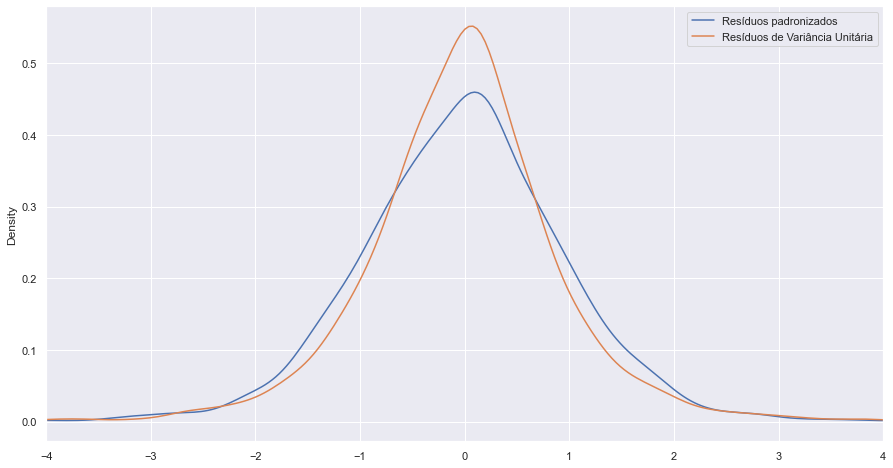

In [440]:
std_resid = residuos_garch / conditional_volatility
unit_var_resid = residuos_garch / residuos_garch.std()
df = pd.concat([std_resid, unit_var_resid], 1)
df.columns = ["Resíduos padronizados", "Resíduos de Variância Unitária"]
subplot = df.plot(kind="kde", xlim=(-4, 4))

In [441]:
acorr_ljungbox(residuos_garch, return_df = True, lags=[20])

,lb_stat,lb_pvalue
20,23.75,0.25


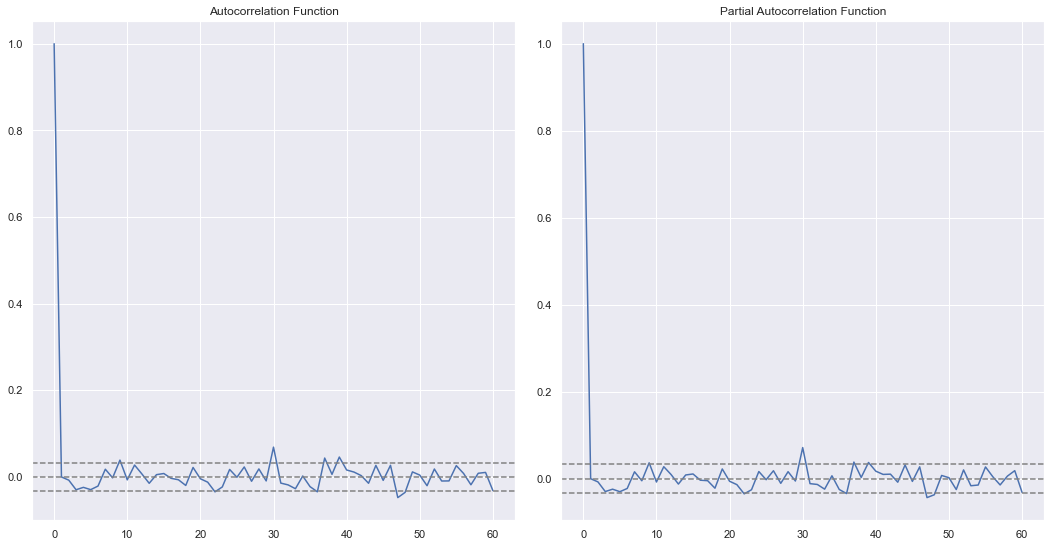

In [442]:
#Resíduos GARCH
plot_acf_and_pacf(residuos_garch, 60)

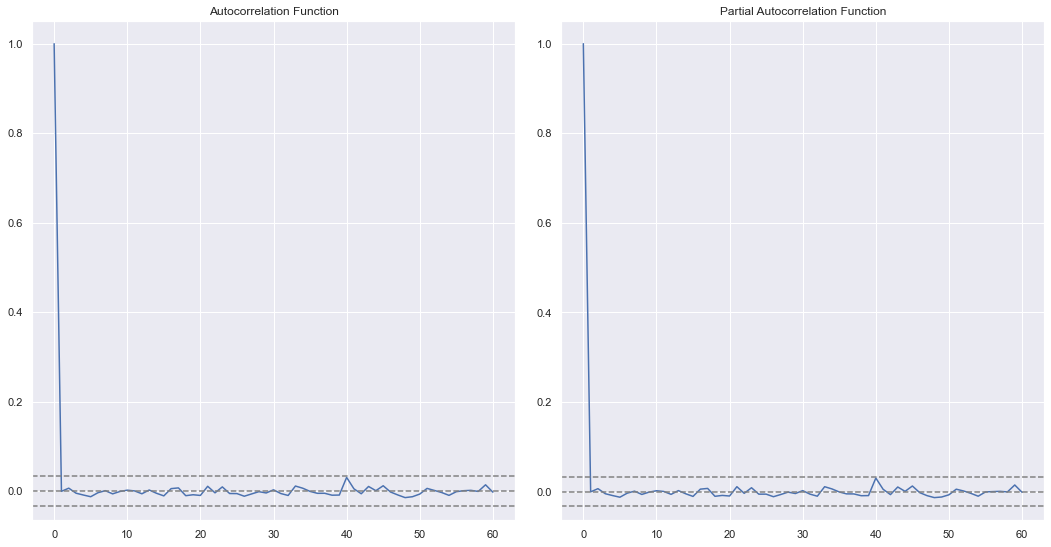

In [443]:
#Resíduos quadrados padronizados
plot_acf_and_pacf(std_resid ** 2, 60)

In [444]:
acorr_ljungbox(std_resid, lags=[30])

,lb_stat,lb_pvalue
30,28.07,0.57


In [445]:
print(f'O teste ARCH-LM apresentou uma estatística-F de {het_arch(std_resid)[2]}')
print(f'O teste ARCH-LM apresentou uma valor-p de {het_arch(std_resid)[3]}')

O teste ARCH-LM apresentou uma estatística-F de 0.12970647842635774
O teste ARCH-LM apresentou uma valor-p de 0.9994383009036256


##### 4.3 Volatilidade estimada

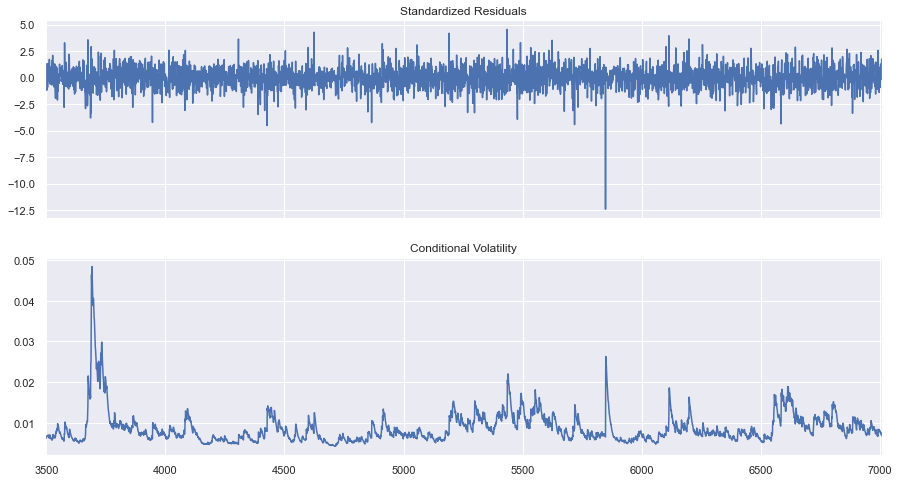

In [464]:
fig = resid_model_results_11.plot()